In [0]:
import tensorflow as tf

assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tarfile
# Extract files in memory so Collab runs quicker
tar = tarfile.open('/content/drive/My Drive/perception_for_robotics/train-jpg.tar')
tar.extractall()
tar.close()

In [0]:
# Filesystem paths
images_folder = '/content/train-jpg/'
tags_file = '/content/drive/My Drive/perception_for_robotics/train_v2.csv'

In [6]:
import pandas as pd

# read the CSV file using pandas
image_tags = pd.read_csv(tags_file)
# show some sample rows and information about the dataset
print(image_tags.describe)

<bound method NDFrame.describe of         image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]>


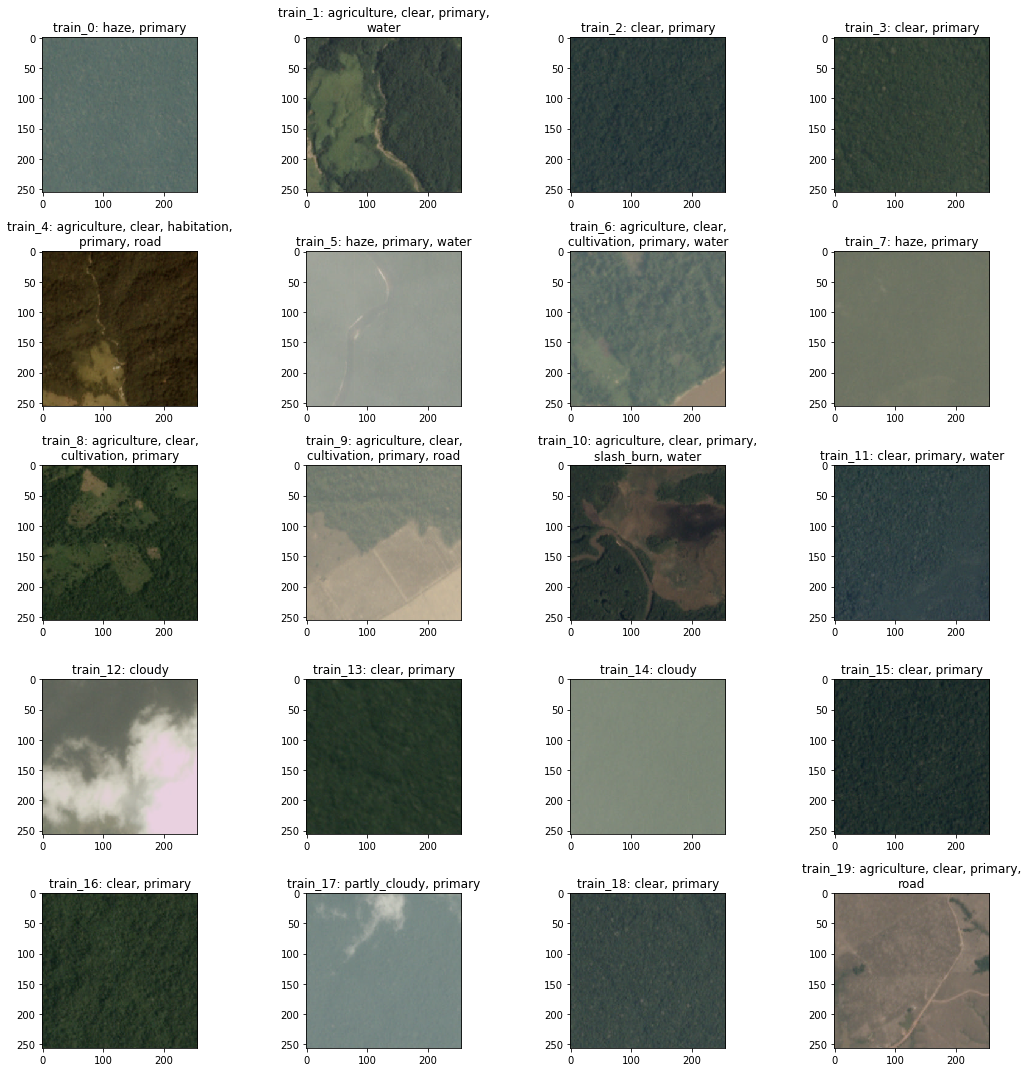

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import textwrap

#
# Display some first images and their tags
#

# Displays images in images_folder in N columns format and with a title
def display_images(image_paths, image_titles, columns):
    # get number of images
    num_images = len(image_paths)
    # calculate rows dinamically
    rows = round(num_images / columns)
    # create a slot for every picture, making the subplot contain N rows and M columns
    fig, axs = plt.subplots(rows, columns, figsize=(15,15)) # fixed figure size
    # make axs object flat so we can iterate over every slot easily
    axs = axs.flatten()
    # indexing paths, titles and axes
    for image_path, image_title, ax in zip(image_paths, image_titles, axs):
        # read the image
        img = mpimg.imread(image_path)
        # display the image
        ax.imshow(img)
        # make sure the images have spacing below to not cover the title
        ax.margins(x=0, y=5)
        # splitting the tags into lines since an image can have multiple tags
        image_title = "\n".join(textwrap.wrap(image_title, 40))
        # add the title to each image
        ax.set_title(image_title)
    # make sure the layout has enough space to show titles and images
    fig.tight_layout()
    # display the plot
    plt.show()


num_display_images = 20
image_paths = []
image_titles = []
for index, row in image_tags.head(num_display_images).iterrows():
    name = row["image_name"]
    image_paths.append(images_folder + name + ".jpg")
    image_titles.append(name + ": " + row["tags"].replace(' ',', '))

# finally, calling the function to display the images and titles in M columns style
display_images(image_paths, image_titles, columns=4)

In [9]:
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

# splits a string into array by spaces, used to split tags
split_spaces = lambda x: x.strip().split(" ")

def load_single_image(filename):
    # we reduce the image size for faster training
    image = load_img(filename, target_size=(128,128))
    # we transform the image to an array of three dimentions (RGB)
    return img_to_array(image)

# creates our X and y datasets
def get_training_data(image_tags, images_path):
    images = []
    # images
    for index, row in image_tags.iterrows():
        images.append(load_single_image(images_path + row["image_name"] + ".jpg"))
    X = np.asarray(images, dtype='uint8')
    
    # labels
    one_hot_tags = []
    # one hot encoder for tags
    one_hot = MultiLabelBinarizer()
    # split all tags into arrays
    tags_array = list(map(split_spaces,image_tags['tags'].values))
    # fit the one-hot encoder with all the tags seen so far
    y = np.asarray(one_hot.fit_transform(tags_array), dtype='uint8')
    
    return X, y, one_hot

Using TensorFlow backend.


In [10]:
# load the jpeg images
X, y, one_hot = get_training_data(image_tags, images_folder)
print(X.shape, y.shape)

(40479, 128, 128, 3) (40479, 17)


In [0]:
print(one_hot.classes_)

import datetime as dt
from time import sleep

t = dt.datetime.now()
minute_count = 60

while True:
    delta_minutes = (dt.datetime.now() -t).seconds / 60                
    if delta_minutes and delta_minutes != minute_count:
        minute_count = delta_minutes
    sleep(1)

['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


We make sure the transformed data is still correct, printing information about image #4
One hot encoding: [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]
Encoded labels: [('agriculture', 'clear', 'habitation', 'primary', 'road')]
Actual labels: agriculture clear habitation primary road
Image array shape: (128, 128, 3)


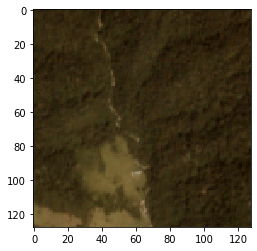

In [11]:
image_test = 4
print("We make sure the transformed data is still correct, printing information about image #"+ str(image_test))
print("One hot encoding:", y[image_test])
print("Encoded labels:", one_hot.inverse_transform(np.array([y[image_test]])))
print("Actual labels:", image_tags.iloc[[image_test]]['tags'].tolist()[0])
print("Image array shape:", X[image_test].shape)
plt.imshow(X[image_test])

In [0]:
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.applications.vgg19 import VGG19
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

def fbeta_score(y_true, y_pred, beta=2):
    # make sure predictions are between the [0,1] range
    y_pred = K.clip(y_pred, 0, 1)
    # calculate precision and recall
    true_positive  = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_positive = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    false_negative = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    precision = true_positive / (true_positive + false_positive + K.epsilon())
    recall    = true_positive / (true_positive + false_negative + K.epsilon())
    # calculate f-beta score
    beta_squared = beta ** 2
    score = K.mean((1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))
    return score
 
# define cnn model
def create_model():
    # load VGG19 transfer model
    vgg_conv = VGG19(include_top=False, input_shape=(128, 128, 3))
    # mark 10 last layers as trainable
    for layer in vgg_conv.layers[:-10]:
        layer.trainable = False
    model = Sequential()
    # Add the vgg convolutional base model
    model.add(vgg_conv)
    # add new classifier layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(17, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta_score])
    return model

In [14]:
# load dataset
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

# create data generator
train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_datagen = ImageDataGenerator(featurewise_center=True)
# set means for centering from VGG transfer learning
train_datagen.mean = [123.68, 116.779, 103.939]
test_datagen.mean = [123.68, 116.779, 103.939]

# prepare iterators
train_it = train_datagen.flow(trainX, trainY, batch_size=128)
test_it = test_datagen.flow(testX, testY, batch_size=128)

# define model
model = create_model()
# checkpoint, save best models
checkpoint_train_loss  = ModelCheckpoint("/content/drive/My Drive/perception_for_robotics/best-train-loss.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint_train_fbeta = ModelCheckpoint("/content/drive/My Drive/perception_for_robotics/best-train-fbeta.hdf5", monitor='fbeta_score', verbose=1, save_best_only=True, mode='max')
checkpoint_test_loss  = ModelCheckpoint("/content/drive/My Drive/perception_for_robotics/best-test-loss.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_test_fbeta = ModelCheckpoint("/content/drive/My Drive/perception_for_robotics/best-test-fbeta.hdf5", monitor='val_fbeta_score', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint_train_loss,checkpoint_train_fbeta,checkpoint_test_loss,checkpoint_test_fbeta]
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1, callbacks=callbacks_list)
# evaluate model
loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)
Epoch 1/10
222/222 [==============================] - 111s 498ms/step - loss: 1.5076 - fbeta_score: 0.6030 - val_loss: 1.5144 - val_fbeta_score: 0.6067

Epoch 00001: loss improved from inf to 1.50733, saving model to /content/drive/My Drive/perception_for_robotics/best-train-loss.hdf5

Epoch 00001: fbeta_score improved from -inf to 0.60307, saving model to /content/drive/My Drive/perception_for_robotics/best-train-fbeta.hdf5

Epoch 00001: val_loss improved from inf to 1.51445, saving model to /content/drive/My Drive/perception_for_robotics/best-test-loss.hdf5

Epoch 00001: val_fbeta_score improved from -inf to 0.60670, saving model to /content/drive/My Drive/perception_for_robotics/best-test-fbeta.hdf5
Epoch 2/10
222/222 [==============================] - 108s 485ms/step - loss: 1.5291 - fbeta_score: 0.6038 - val_loss: 1.5144 - val_fbeta_score: 0.6067

Epoch 00002: loss did not improve from 1.50733

Epoch 00002: fbeta_sc

In [0]:
import tarfile
# Extract test files into memory
tar = tarfile.open('/content/drive/My Drive/perception_for_robotics/test-jpg.tar')
tar.extractall()
tar.close()

In [0]:
import tarfile
# Extract test-additional files into memory
tar = tarfile.open('/content/drive/My Drive/perception_for_robotics/test-additional-jpg.tar')
tar.extractall()
tar.close()

In [0]:
# We try our best model trained so far to make actual predictions
best_model = create_model()
model_path = "/content/drive/My Drive/perception_for_robotics/best_models_nov_26_2019/best-test-loss.hdf5"
best_model.load_weights(model_path)
print("Loaded model from disk: %s" % model_path)

Loaded model from disk: /content/drive/My Drive/perception_for_robotics/best_models_nov_26_2019/best-test-loss.hdf5


In [0]:
from os import listdir
from os.path import isfile, join

# creates our X and y datasets
def get_kaggle_test_data(path):
    images = []
    # get all files in the path
    image_names = [f.replace(".jpg","") for f in listdir(path) if isfile(join(path, f))]
    # create our array
    for image_name in image_names:
        image = load_single_image(path + image_name + ".jpg") # - [123.68, 116.779, 103.939]
        images.append(image)
    return np.asarray(images, dtype='uint8'), image_names

print("Loading test images")
X_test_jpg, names_test_jpg = get_kaggle_test_data('/content/test-jpg/')
print(X_test_jpg.shape)
print("Loading additional test images")
X_test_jpg_additional, names_test_jpg_additional = get_kaggle_test_data('/content/test-jpg-additional/')
print(X_test_jpg_additional.shape)

Loading test images
(40669, 128, 128, 3)
Loading additional test images
(20522, 128, 128, 3)


In [0]:
# predict test data
prediction = []
print("Predicting first batch of test images")
for image in X_test_jpg:
  prediction.append(best_model.predict(np.array([image]))[0].round())
print("Predicting additional batch of test images")
for image in X_test_jpg_additional:
  prediction.append(best_model.predict(np.array([image]))[0].round())

Predicting first batch of test images
Predicting additional batch of test images


In [0]:
prediction = np.array(prediction)
inverse_predictions = [" ".join(p) for p in one_hot.inverse_transform(prediction)]
names = np.concatenate((names_test_jpg, names_test_jpg_additional))
dataset = pd.DataFrame({'image_name': names, 'tags': inverse_predictions})

In [0]:
print(dataset)
dataset.to_csv('/content/drive/My Drive/perception_for_robotics/kaggle_submission_final.csv')

       image_name                                      tags
0      test_36858           agriculture clear primary water
1      test_35183                     partly_cloudy primary
2      test_21765               partly_cloudy primary water
3      test_32118            agriculture clear primary road
4      test_24084      agriculture clear habitation primary
...           ...                                       ...
61186  file_14911                             clear primary
61187  file_15838                             clear primary
61188   file_1269                                    cloudy
61189  file_11968                             clear primary
61190  file_11886  agriculture habitation haze primary road

[61191 rows x 2 columns]


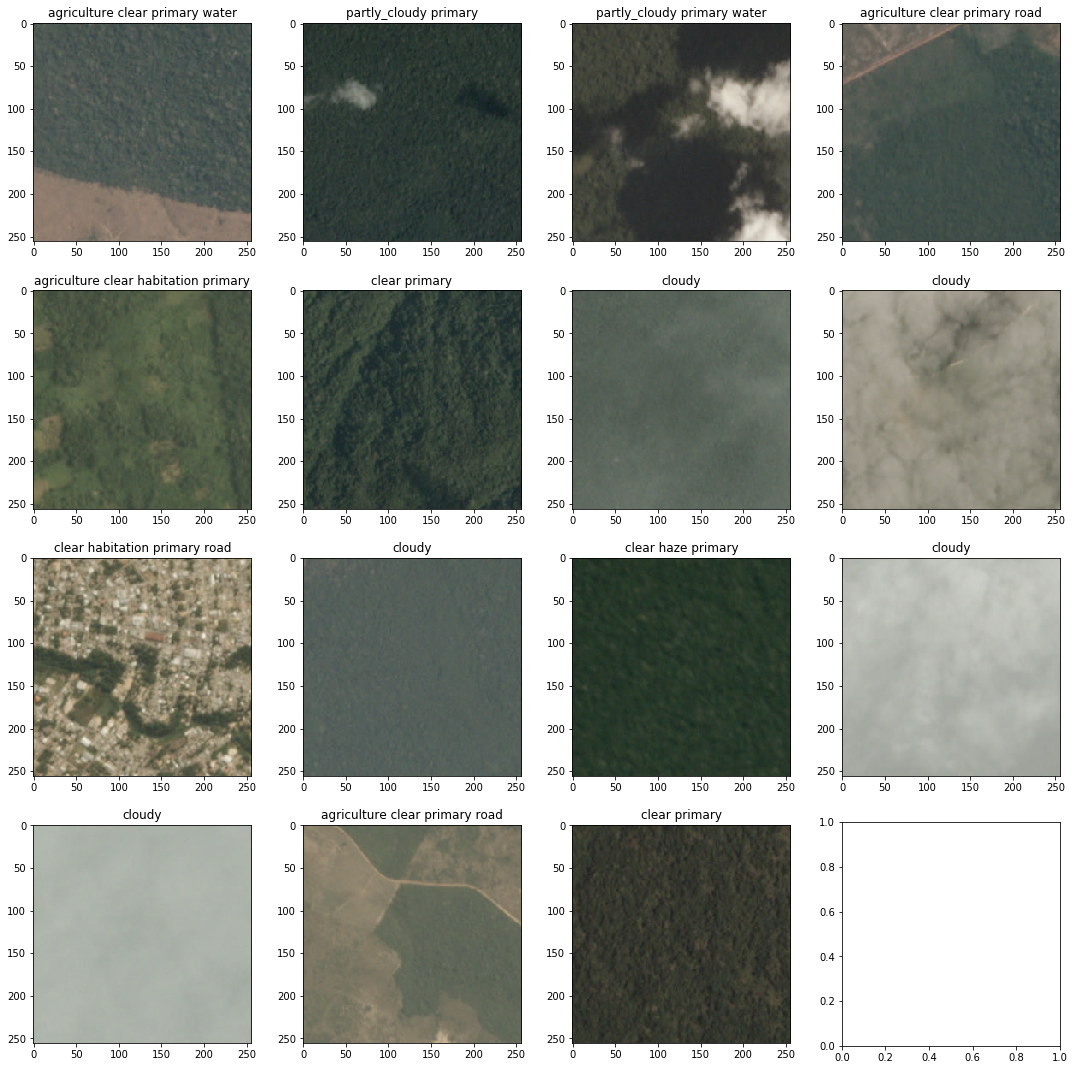

In [0]:
num_images = 15
image_titles = inverse_predictions[:num_images]
image_paths = ["/content/test-jpg/" + n + ".jpg" for n in names[:num_images]]
display_images(image_paths, image_titles, columns=4)